# Aggregated SHAP values: understanding feature importances for finetuned DistilBERT model

SHAP values are assigned PER TOKEN PER INSTANCE (local explanation). By aggregating SHAP values across instances, we can get insights about which features (i.e., tokens) are important for the classification task (global explanation).


Features == tokens


3 types of aggregation:

- at the token level: look at shap values of individual tokens across instances and average across occurrences of each token.

- at the ngram level: look at ngrams across instances (any value of n). The SHAP value of an ngram is the sum of the SHAP values of its constituent tokens divided by n. Then, average across occurrences of each ngram.

- at the chunk level: look at consecutive tokens that get the exact same SHAP values, treat them as a chunk whose SHAP values are the one of any of its constituent tokens (since they are all the same). Then, average across occurrences of each chunk.


2 types of average:

- per class: average contribution of a token WHEN IT DOES CONTRIBUTE to a class prediction (magnitude of contribution when it contributes)

- overall: average contribution of a token across all instances where it appears, regardless of whether it contributes to the prediction or not (by averaging we can see whether on average it contributes more to pos/neg class)

In [2]:
import json
import os
import pandas as pd
import numpy as np
import pickle as pkl

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
SHAP_DIR = os.path.join(PROJECT_DIR, 'classification/shap_values/coqa/')
MASK_DIR = os.path.join(SHAP_DIR, 'masktoken_mask_default')

Results from shap analysis stored in json files - eg.: 

`classification/shap_values/coqa/agg-sv_distilbert_class-avg_3gram_test.json`

__
**Overall averaging e.g.:**

TOKEN (now WORD)

{"": 0.00091, "first": 3e-05, "identify": -0.0001, "the": 0.00414, "geographic": -0.0004, ...}


NGRAM

{"<BOS> first ,": -0.0001, "first , we": 0.00027, ", we need": 0.00042, "we need to": 0.00055, ...}


CHUNK

{"first,": -6e-05, "we need to identify": 0.00035, "the geographic feature mentioned": -0.00075, ...}


If the value is negative, it means that the token contributes ot the negative class. If the value is positive, it means that the token contributes to the positive class. The absolute value is the magnitude of the contribution.

__
**Class averaging e.g.:**


TOKEN

{"": [-0.00035, 0.00135], "first": [-0.00052, 0.00052], ",": [-0.0034, 0.00165], ...}


NGRAM

{"<BOS> first ,": [-0.00051, 0.00031], "first , we": [-0.00019, 0.00041], ", we need": [-0.00037, 0.00066], ...}


CHUNK

{"first,": [-0.00042, 0.00029], "we need to identify": [-0.00076, 0.00074], "the geographic feature mentioned": [-0.00075, 0], "in the": [-0.00206, 0.00491], ...}


Here we have 2 values for each entity. The first value is the contribution to the negative class, and the second value is the contribution to the positive class. The absolute value of each is the magnitude of the contribution to the respective class.

In [3]:
entity_frequency_dict = json.load(open(os.path.join(SHAP_DIR, 'distilbert_entity_frequency_test_empty.json'), 'r'))
entity_frequency_dict_mask = json.load(open(os.path.join(SHAP_DIR, 'masktoken_mask_default', 'distilbert_entity_frequency_test_mask.json'), 'r'))

In [1]:
def visualize_shap_results(shap_file, n_features=10):

    freq_dict = entity_frequency_dict
    load_from_dir = SHAP_DIR
    entity_type = shap_file.split('_')[3]+'s'

    # Relevant for chunk-level shap values
    # Using different mask tokens leads to different chunks
    # + values derived with mask_token==[MASK] are in a different DIR
    if 'mask' in shap_file:
        freq_dict = entity_frequency_dict_mask
        load_from_dir = MASK_DIR

    if 'class-avg' in shap_file:
        with open(os.path.join(load_from_dir, shap_file), 'r') as f:
            shap_results = json.load(f)

        # Get frequency info and filter out tokens with frequency < 10
        sorted_neg = [
            (k, v) for k, v in sorted(shap_results.items(), key=lambda item: item[1][0])
            if freq_dict[entity_type][k] >= 10
        ]
        top_n_neg = sorted_neg[:n_features]
        neg_df = pd.DataFrame(top_n_neg, columns=['token', 'shap_values'])
        neg_df['shap_neg'] = neg_df['shap_values'].apply(lambda x: float(x[0]))
        neg_df['shap_pos'] = neg_df['shap_values'].apply(lambda x: float(x[1]))
        neg_df = neg_df.drop(columns=['shap_values'])
        
        sorted_pos = [
            (k, v) for k, v in sorted(shap_results.items(), key=lambda item: item[1][1])
            if freq_dict[entity_type][k] >= 10
        ]
        top_n_pos = sorted_pos[-n_features:]
        pos_df = pd.DataFrame(top_n_pos, columns=['token', 'shap_values'])
        pos_df['shap_neg'] = pos_df['shap_values'].apply(lambda x: float(x[0]))
        pos_df['shap_pos'] = pos_df['shap_values'].apply(lambda x: float(x[1]))
        pos_df = pos_df.drop(columns=['shap_values'])

        top_shap_values = pd.merge(neg_df, pos_df, how='outer')

        # add frequency info: add to name of token
        top_shap_values['token'] = top_shap_values['token'].apply(
            lambda x: x + f" ({freq_dict[entity_type][x]})"
        )

        top_shap_values.plot(x='token', y=['shap_neg', 'shap_pos'], kind='barh', figsize=(20, 10))
        
    else:
        with open(os.path.join(load_from_dir, shap_file), 'r') as f:
            shap_results = json.load(f)
        
        sorted_shap_results = {
            k: v for k, v in sorted(shap_results.items(), key=lambda item: item[1])
        }
        
        shap_df = pd.DataFrame(sorted_shap_results.items(), columns=['token', 'shap_value'])

        # add frequency column
        shap_df['frequency'] = shap_df['token'].apply(
            lambda x: freq_dict[entity_type][x]
        )
        # filter out tokens with frequency < 10
        shap_df = shap_df[shap_df['frequency'] >= 10]

        top_n_neg = shap_df.head(n_features)
        top_n_pos = shap_df.tail(n_features)
        top_shap_values = pd.merge(top_n_neg, top_n_pos, how='outer')

        # add frequency to name of token
        top_shap_values['token'] = top_shap_values['token'].apply(
            lambda x: x + f" ({freq_dict[entity_type][x]})"
        )
    
        top_shap_values.plot(x='token', y='shap_value', kind='barh', figsize=(20, 10))

    return top_shap_values

# Aggregations (global explanation)

## Token-level

### Overall avg

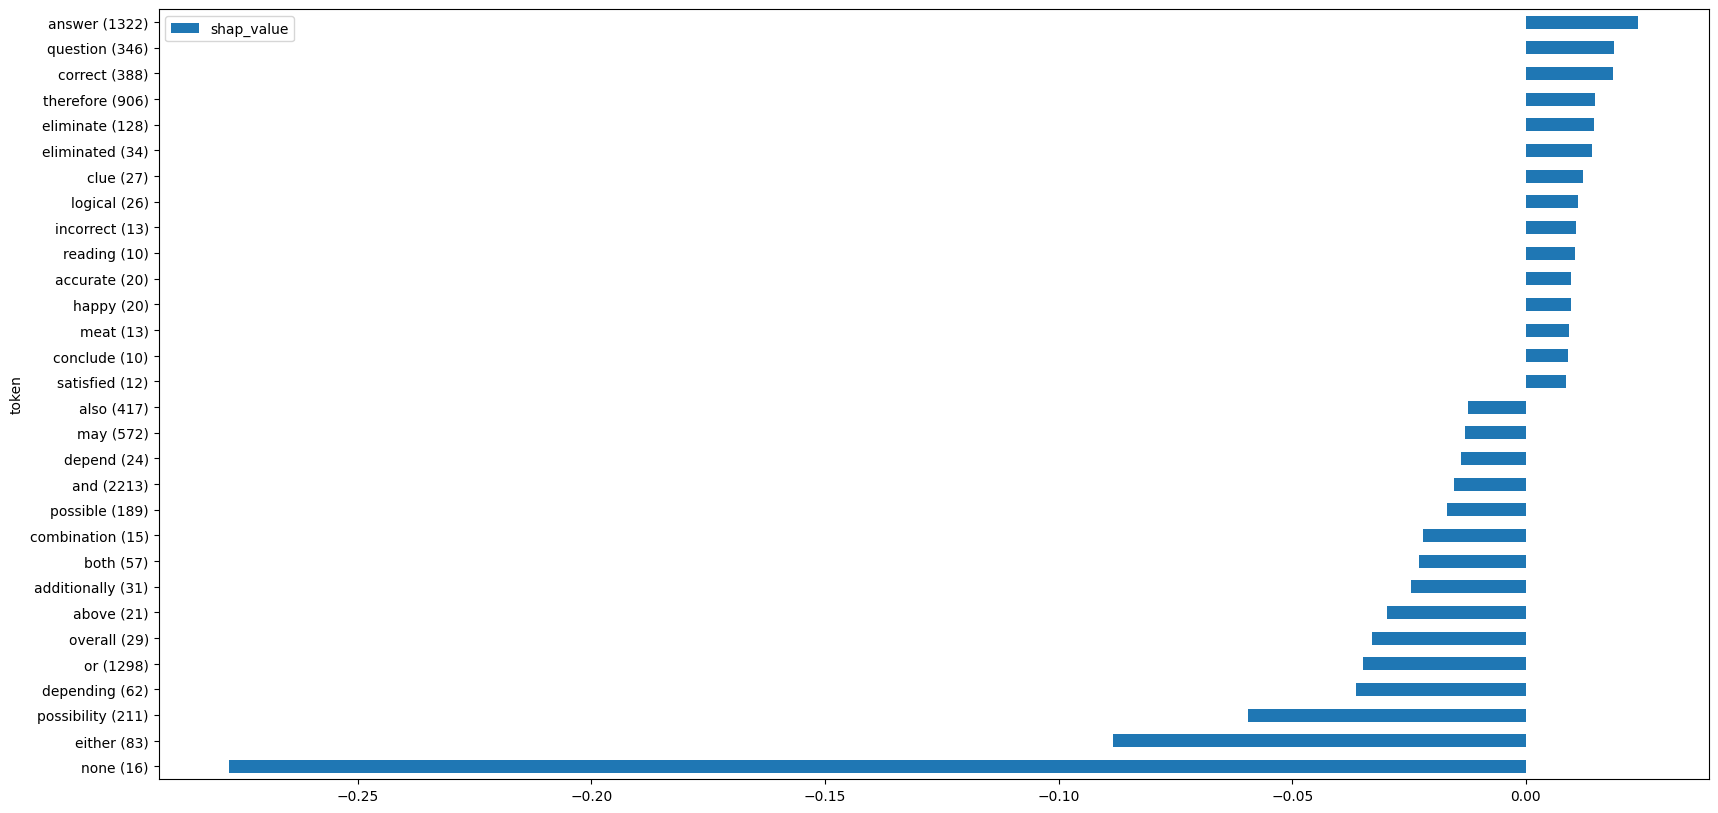

In [4]:
top_tokens_overall = visualize_shap_results('agg-sv_distilbert_overall-avg_token_test.json', n_features=15)
#top_tokens_overall

### Per class avg

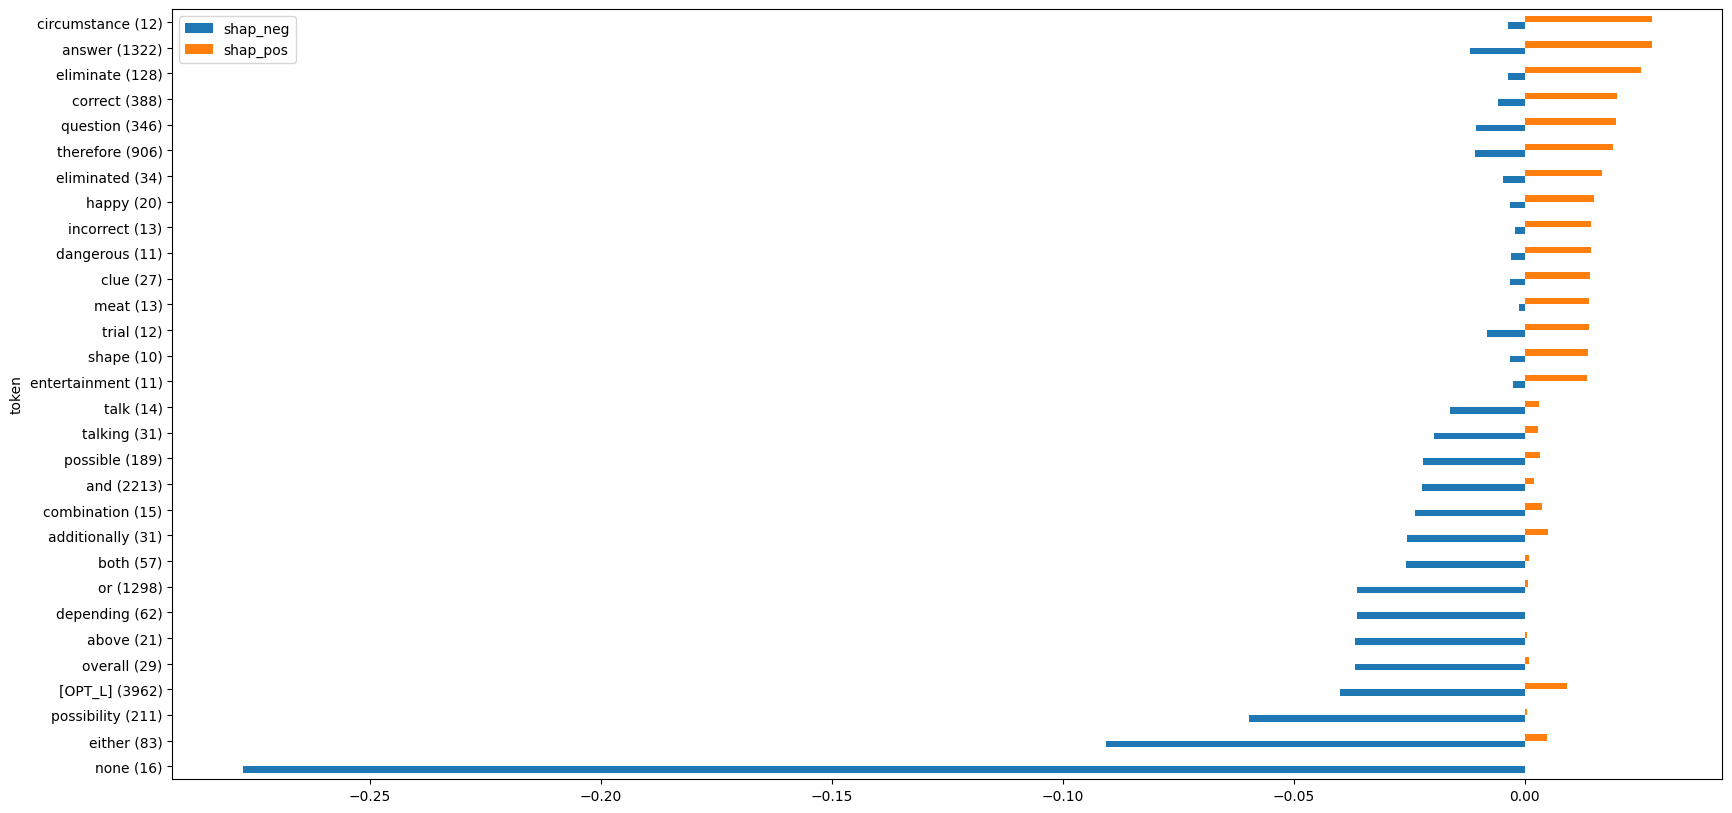

In [44]:
top_tokens_class = visualize_shap_results('agg-sv_distilbert_class-avg_token_test.json', n_features=15)
#top_tokens_class

## 3gram-level

### Overall avg

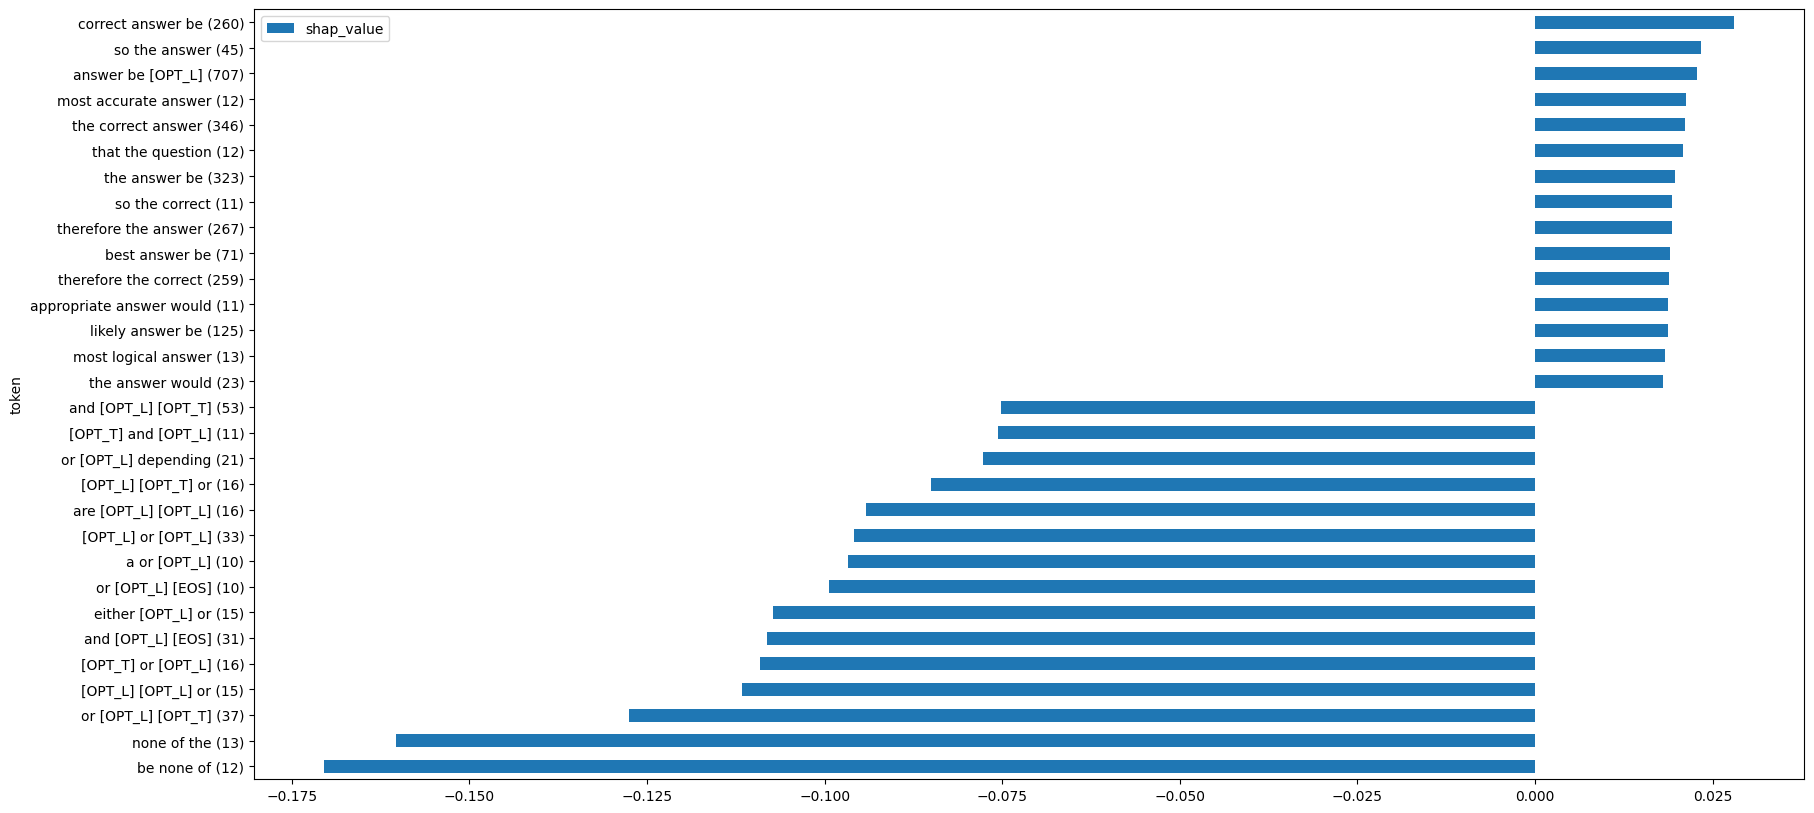

In [46]:
top_3grams_overall = visualize_shap_results('agg-sv_distilbert_overall-avg_3gram_test.json', n_features=15)

### Per class avg

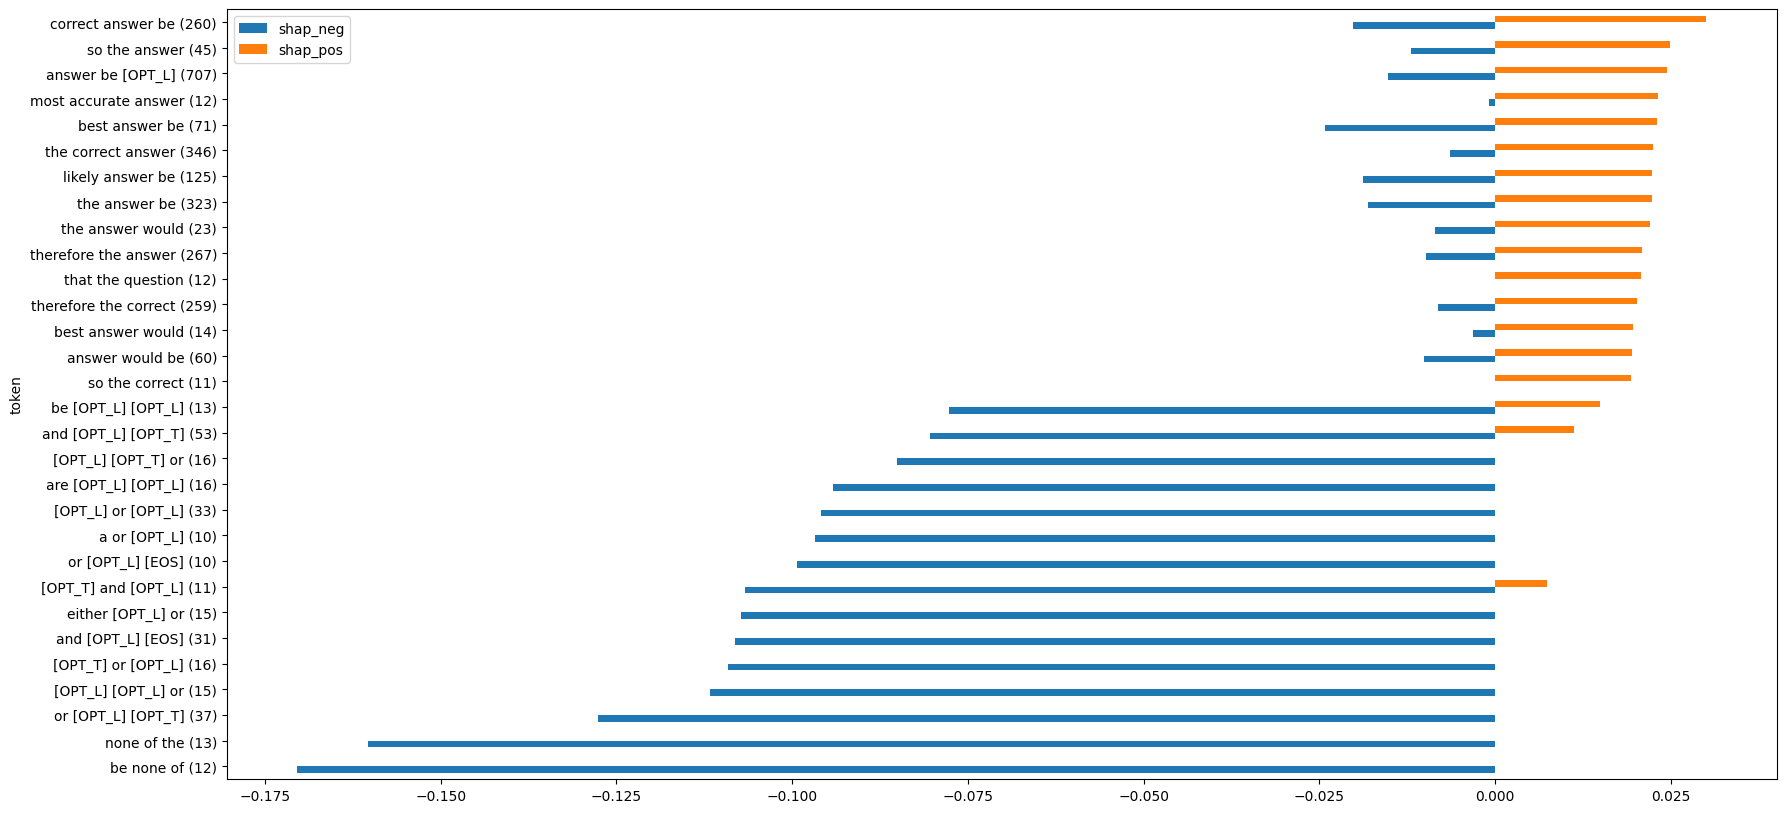

In [48]:
top_3grams_class = visualize_shap_results('agg-sv_distilbert_class-avg_3gram_test.json', n_features=15)
#top_3grams_class

## 5gram-level

### Overall avg

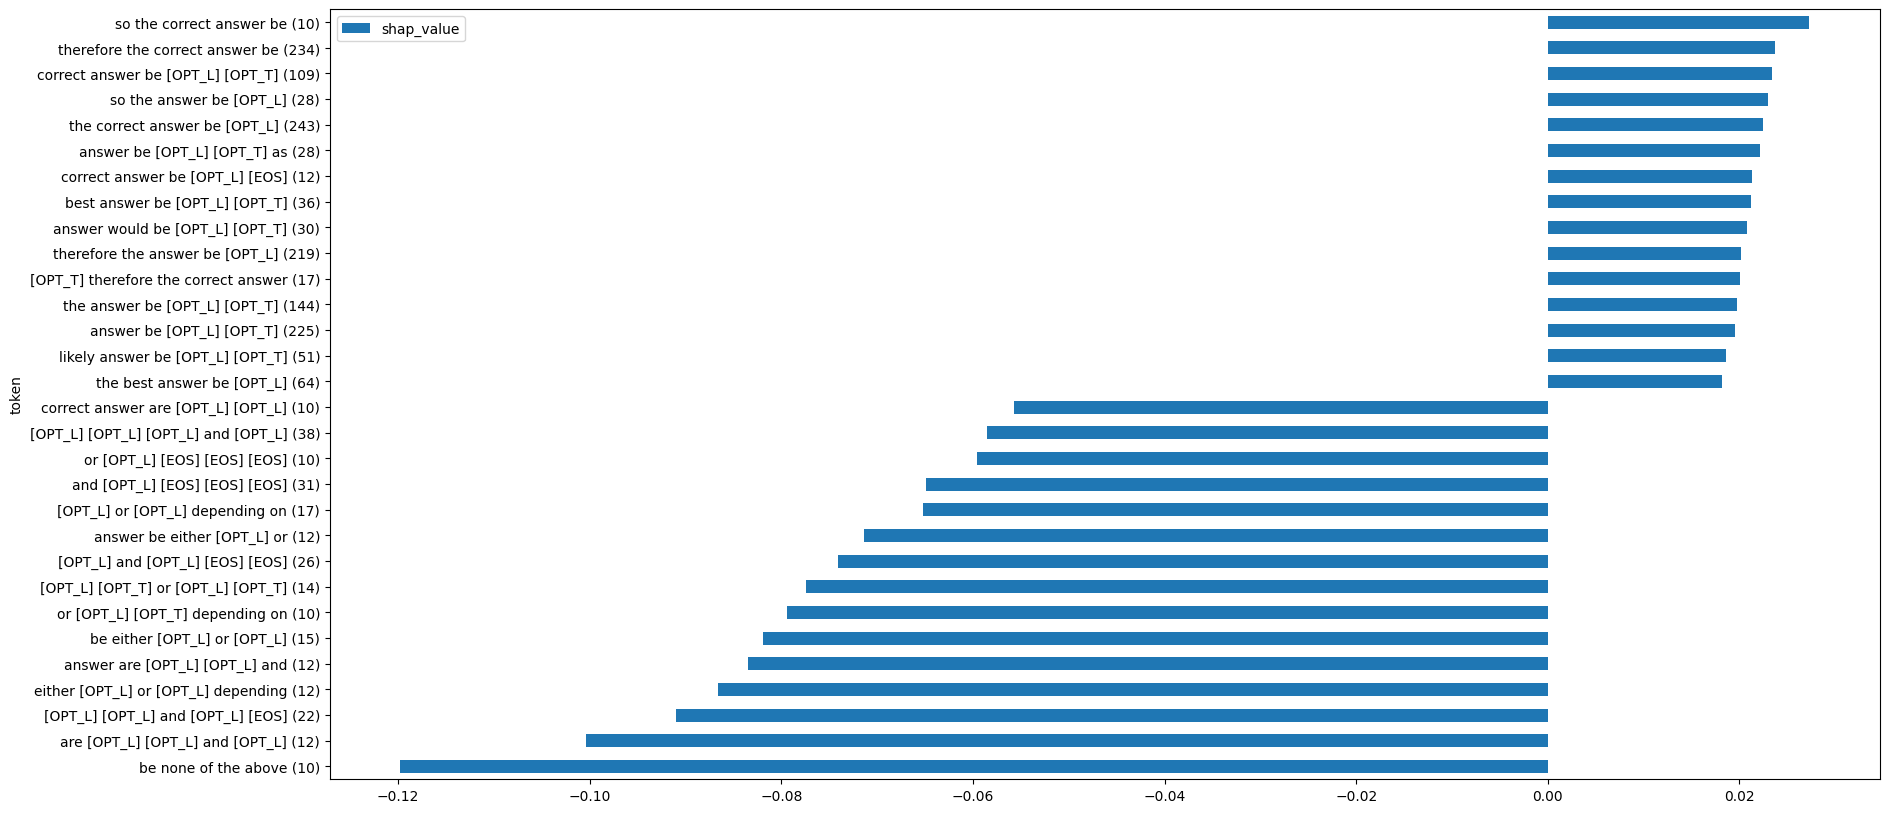

In [50]:
top_5grams_overall = visualize_shap_results('agg-sv_distilbert_overall-avg_5gram_test.json', n_features=15)

### Per class avg

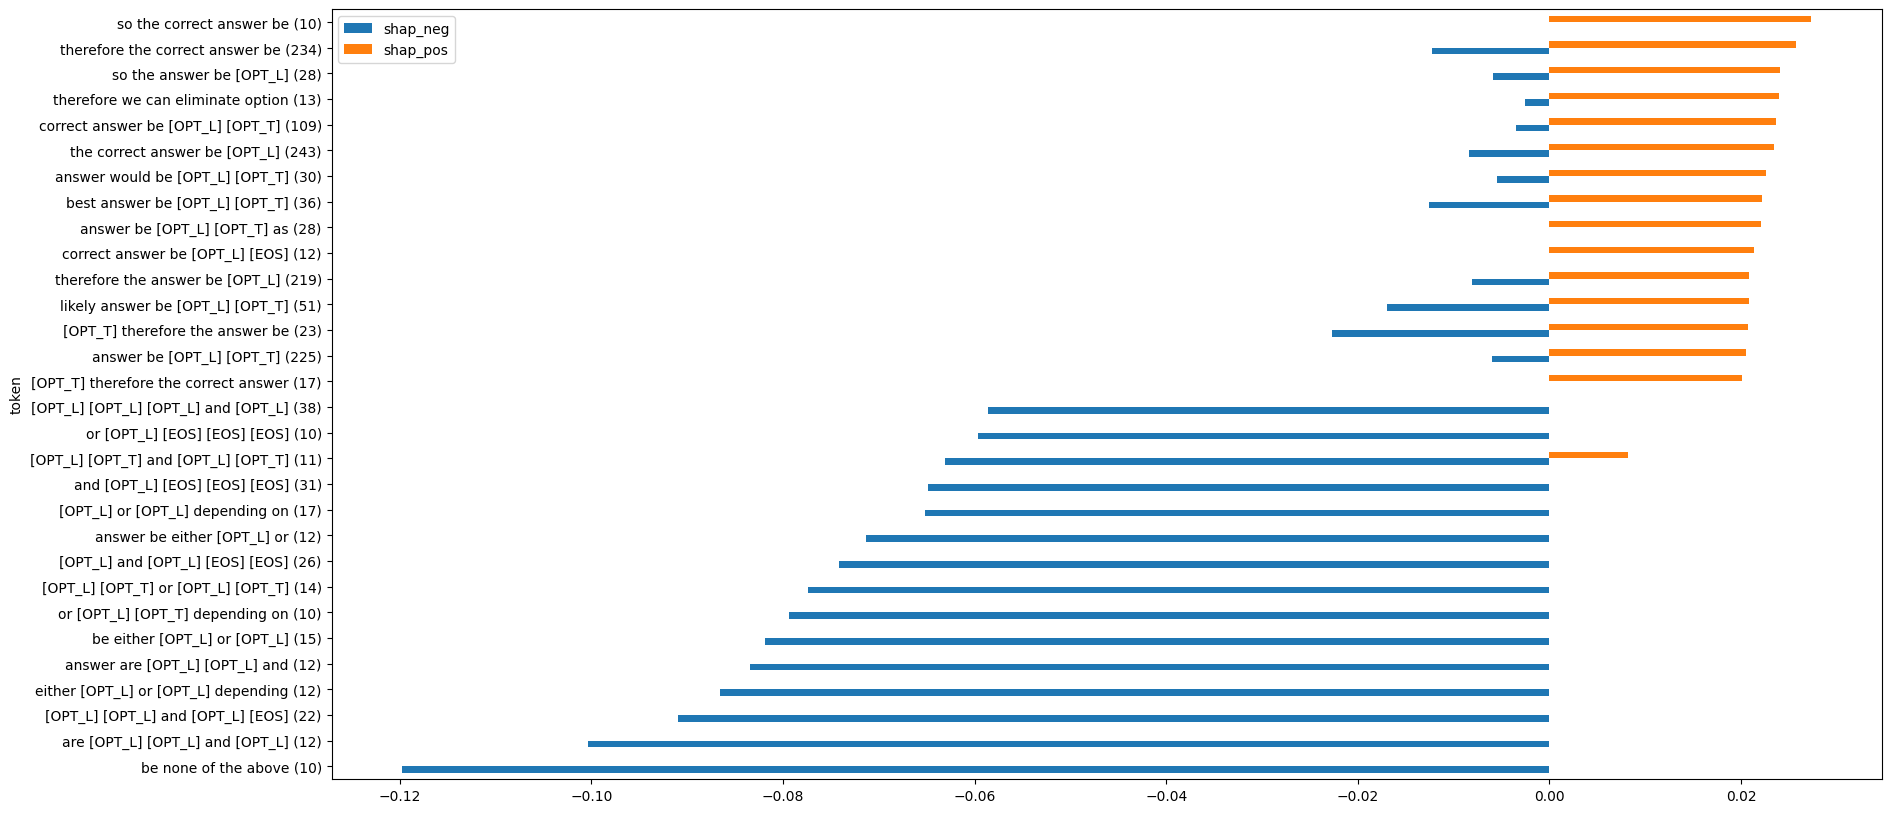

In [52]:
top_5grams_class = visualize_shap_results('agg-sv_distilbert_class-avg_5gram_test.json', n_features=15)

## Chunck-level

### Overall avg

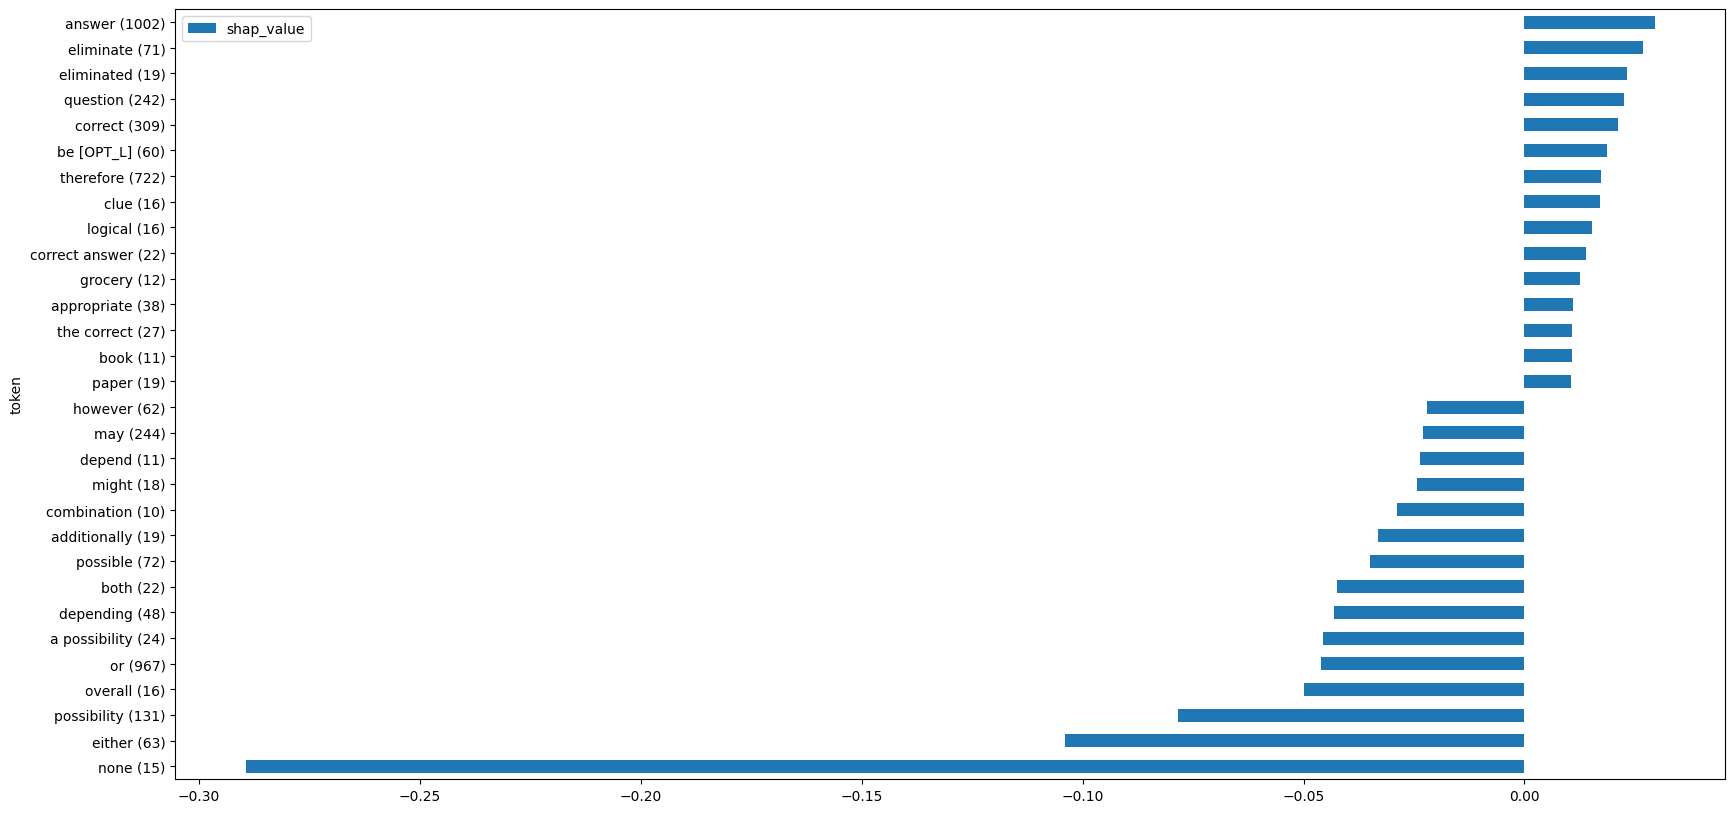

In [54]:
top_chunks_overall = visualize_shap_results('agg-sv_distilbert_overall-avg_chunk_test.json', n_features=15)
#top_chunks_overall

### Per class avg

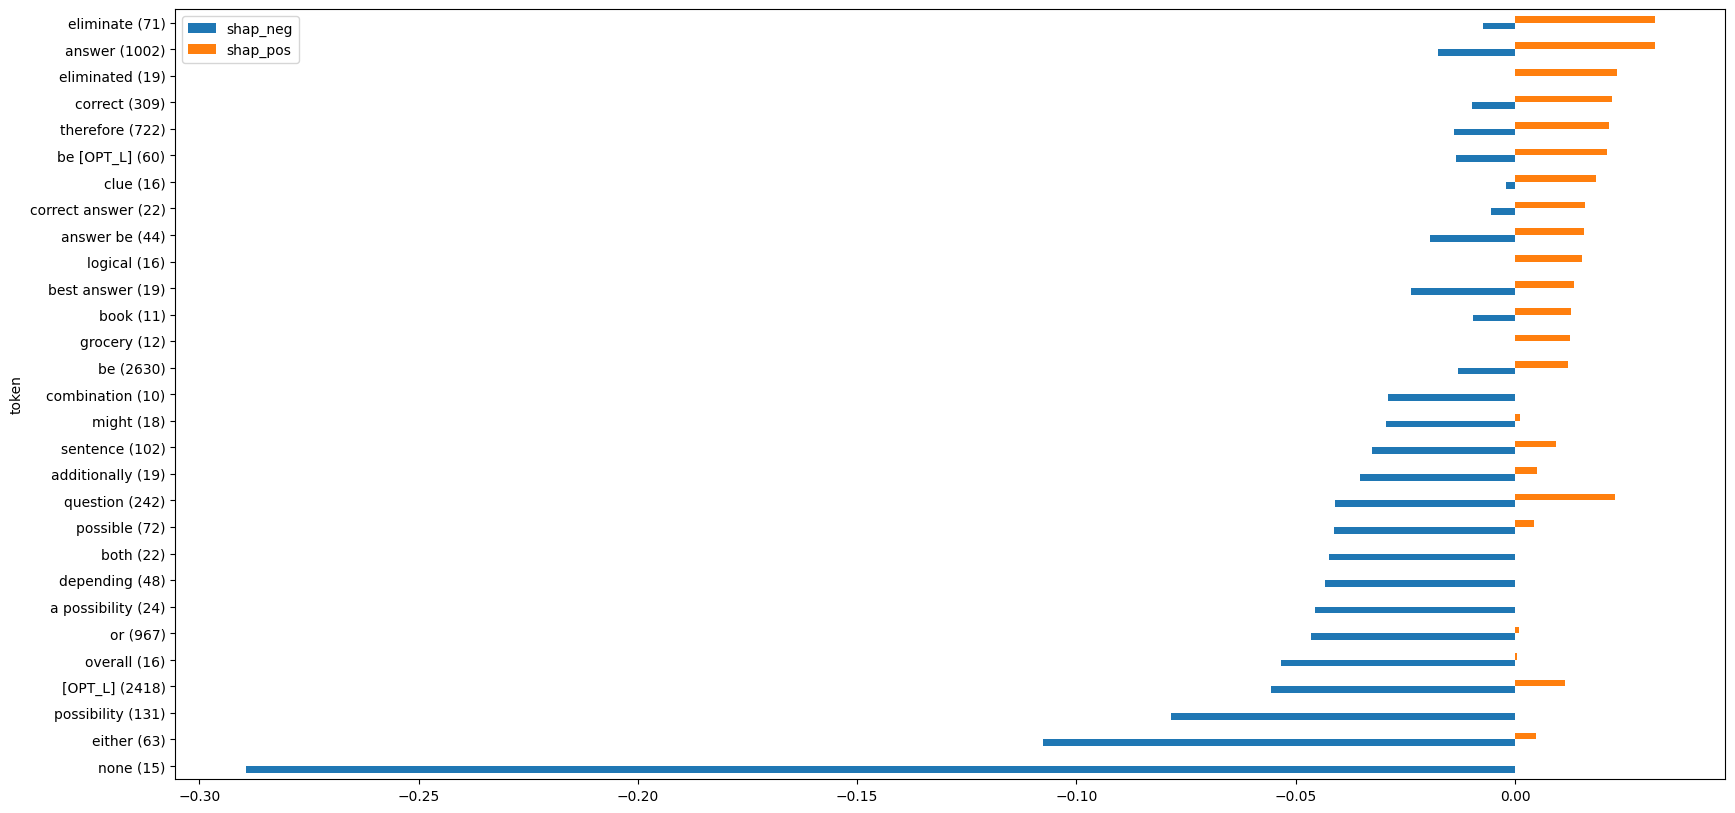

In [56]:
top_chunks_class = visualize_shap_results('agg-sv_distilbert_class-avg_chunk_test.json', n_features=15)
#top_chunks_class

# Instance-level (local explanation)

to do...